# Parameter guesses

This document is the GPyTorch version of the parameter_guesses file that was originally made with GPy.

### Library imports and defaults

In [1]:
from scipy.io import wavfile as wav
import gpytorch
import torch
import GPy
import math
import numpy

%pylab inline
figsize(15, 5)

Populating the interactive namespace from numpy and matplotlib


### Helper functions
Define some helper functions for common functionality

In [2]:
# Print the hyperparameters of the given kernel
# Useful for keeping track of values during training
def print_kernel_parameters(kernel):
    def composition_decorator(k):
        if hasattr(k, 'base_kernel'):
            standard(k)
            composition_decorator(k.base_kernel)
            
        elif hasattr(k, 'kernels'):
            for i in k.kernels:
                composition_decorator(i)
                
        else: standard(k)
        
    def standard(k):
        print('  ' + type(k).__name__)
        for parameter_name, parameter in k.named_parameters():
            if parameter_name.startswith('base_kernel'):
                break
            constraint = k.constraint_for_parameter_name(parameter_name)
            true_name = parameter_name.replace('raw_', '')
            true_value = str(round(constraint.transform(parameter).item(), 4))
            print('    ' + true_name + ': ' + true_value)
        
    composition_decorator(kernel)
        

# Training loop for training a model
def train_model(model, likelihood, verbose = False):
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
    ], lr=0.1)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    training_iter = 1000
    print('--- Optimizing hyperparameters ---')
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_T)
        loss = -mll(output, train_X)
        loss.backward()
    
        if verbose and (i + 1) % 100 is 0:
            print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(), model.likelihood.noise.item()
            ))
            
            print_kernel_parameters(model.covar_module)
            print('')
        
        optimizer.step()

# Data

Normalize data and visualize it.

In [3]:
rate, data = wav.read('../data/3-notes.wav')
data = data/amax(abs(data))
data -= mean(data)  # Remove inaudible DC component (i.e., the mean)
print('Data mean =', mean(data))

x = data[:, 0]
t = arange(len(x))*1000./rate

Data mean = 2.8926513961913258e-18


Text(0, 0.5, 'amplitude (a.u.)')

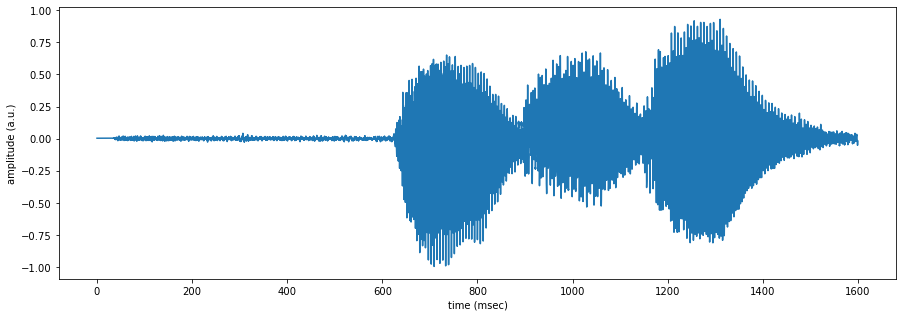

In [4]:
plot(t, x)
xlabel('time (msec)')
ylabel('amplitude (a.u.)')

In [5]:
first_note = x[6100:6500]
second_note = x[7800:8200]
third_note = x[10000:10400]

full_t = linspace(0, 400*1000./rate, 400)  # msec
full_x = first_note

train_t = concatenate((full_t[:200], full_t[300:]))
train_x = concatenate((full_x[:200], full_x[300:]))
test_t = full_t[200:300]
test_x = full_x[200:300]

# Transform to tensors for use in GPyTorch
full_T = torch.as_tensor(full_t)
full_X = torch.as_tensor(full_x)
train_T = torch.as_tensor(train_t)
train_X = torch.as_tensor(train_x)
test_T = torch.as_tensor(test_t)
test_X = torch.as_tensor(test_x)

# Acquire prior information

Standard deviation of the data (a.u.) = 0.4135955264142795
Dominant frequency component (Hz) = 320.0
Corresponding period (msec) =  3.125


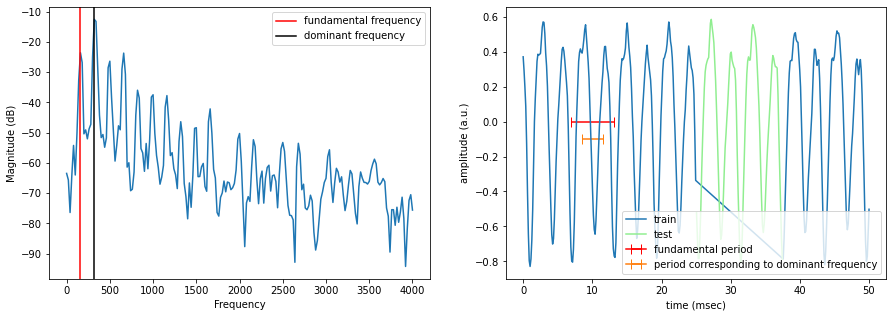

In [6]:
var_x = var(train_x)
std_x = sqrt(var_x)
print('Standard deviation of the data (a.u.) =', std_x)

figsize(15, 5)
subplot(121)
spectrum, freqs, _ = magnitude_spectrum(full_x, Fs=rate, scale='dB')

# Find and annotate dominant frequency component (largest peak in the spectrum)
fmax = freqs[argmax(spectrum)]  # Hz
f0 = fmax/2  # Hz
Tmax = 1000./fmax  # msec
T0 = Tmax*2  # msec

axvline(x=f0, label='fundamental frequency', color='red')
axvline(x=fmax, label='dominant frequency', color='black')
legend()

subplot(122)
plot(train_t, train_x, '-', label='train')
plot(test_t, test_x, '-', label='test', color='lightgreen')
errorbar(10, 0, xerr=T0/2, capsize=5, label='fundamental period', color='red')
errorbar(10, -.1, xerr=Tmax/2, capsize=5,
         label='period corresponding to dominant frequency')
xlabel('time (msec)')
ylabel('amplitude (a.u.)')
legend()

print('Dominant frequency component (Hz) =', fmax)
print(f'Corresponding period (msec) = ', Tmax)

# RBF kernel

## Vanilla kernel
Parameters of the kernel are guessed based on the acquired prior information.

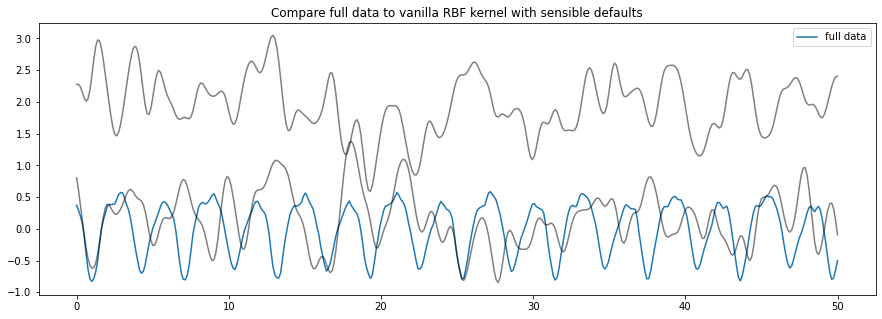

In [7]:
def SNR_to_noise_power(signal_power, SNR_dB):
    """
    Solve the SNR formula

        SNR_dB = 10 log10[signal_power/noise_power]

    for noise_power.
    """
    noise_power = signal_power*10.**(-SNR_dB/10.)
    return noise_power


SNR = 20  # dB
noise_var = SNR_to_noise_power(var_x, SNR)

# Derive lengthscale from expected number of zero upcrossings in unit interval (1 msec)
# We derive the number of zero upcrossings per msec from the dominant frequency component
# Formula from Rasmussen & Williams (2006, 83)
ell_guess = Tmax/(2*pi)

kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
kernel.outputscale = var_x
kernel.base_kernel.lengthscale = ell_guess

cov = kernel(full_T)

title('Compare full data to vanilla RBF kernel with sensible defaults')
plot(full_t, full_x, label='full data')
legend()
n = 2
for i in range(n):
    x0 = multivariate_normal(full_t*0., cov.numpy())
    plot(full_t, 2*i + x0, alpha=1/n, color='black')

## Model with Vanilla kernel
The model represents noise as a Gaussian likelihood that is included in the model.

--- Signal to Noise Ratio (SNR) ---
Equivalent SNR over full data (dB) = 19.999999202205036
SNR at test data (dB) = 0.7036519075213228


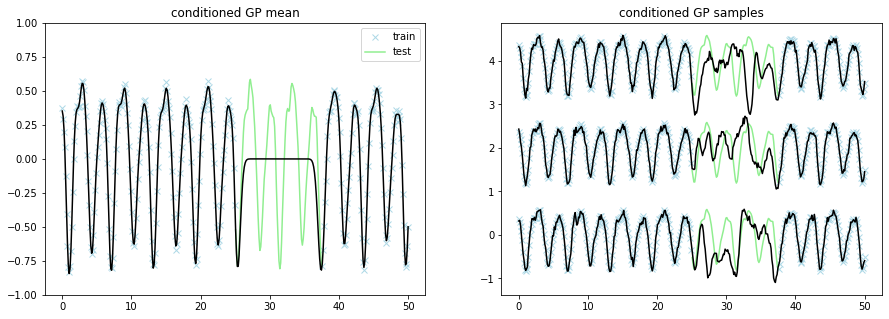

In [8]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, kernel, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = noise_var
model = ExactGPModel(train_T, train_X, kernel, likelihood)

%run display_model.ipy

## Optimize model hyperparameters
Train the model in order to improve the hyperparameters of the kernel.

In [9]:
train_model(model, likelihood)

--- Optimizing hyperparameters ---


In [10]:
lengthscale = model.covar_module.base_kernel.lengthscale.item()
zero_crossing_rate_per_msec = 1 / (lengthscale*2*pi)
print('Equivalent mean zero upcrossing rate (Hz) =',
      1000. / (lengthscale*2*pi))

Equivalent mean zero upcrossing rate (Hz) = 448.2991084761511


--- Signal to Noise Ratio (SNR) ---
Equivalent SNR over full data (dB) = 31.731215360703956
SNR at test data (dB) = 0.9818400174883974


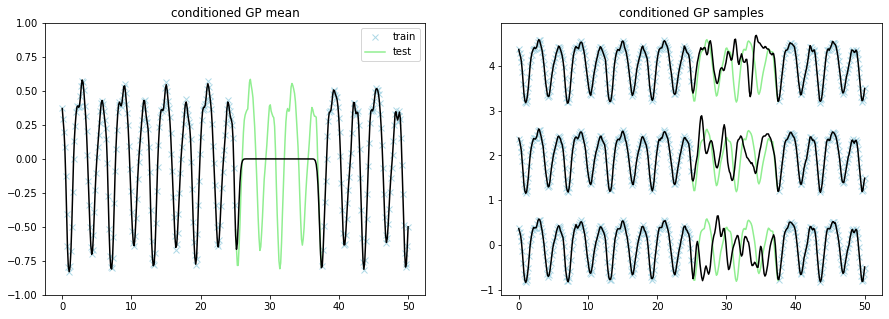

In [11]:
%run display_model.ipy

# Periodic kernel

## Vanilla kernel

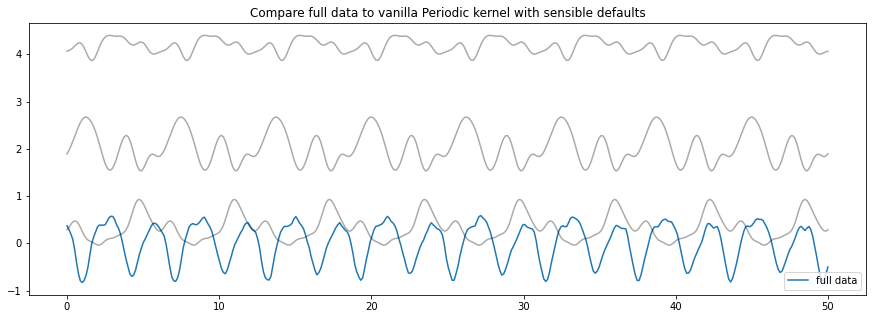

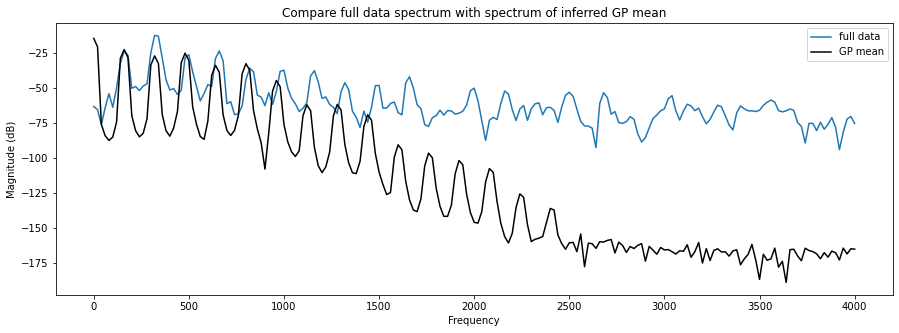

In [12]:
ell_period_guess = T0/(4*pi)

kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
kernel.outputscale = var_x
kernel.base_kernel.lengthscale = ell_period_guess
kernel.base_kernel.period_length = T0

cov = kernel(full_T)

title('Compare full data to vanilla Periodic kernel with sensible defaults')
plot(full_t, full_x, label='full data')
legend()
n = 3
for i in range(n):
    x0 = multivariate_normal(full_t*0., cov.numpy())
    plot(full_t, 2*i + x0, alpha=1/n, color='black')

show()

title('Compare full data spectrum with spectrum of inferred GP mean')
magnitude_spectrum(full_x, rate, scale='dB', label='full data')
magnitude_spectrum(x0, rate, scale='dB',
                   color='black', label='GP mean')

legend()
show()

## Optimize

In [13]:
likelihood.noise_covar.noise = noise_var
model = ExactGPModel(train_T, train_X, kernel, likelihood)

train_model(model, likelihood)

--- Optimizing hyperparameters ---


--- Signal to Noise Ratio (SNR) ---
Equivalent SNR over full data (dB) = 22.79183558092209
SNR at test data (dB) = 23.844375964722367


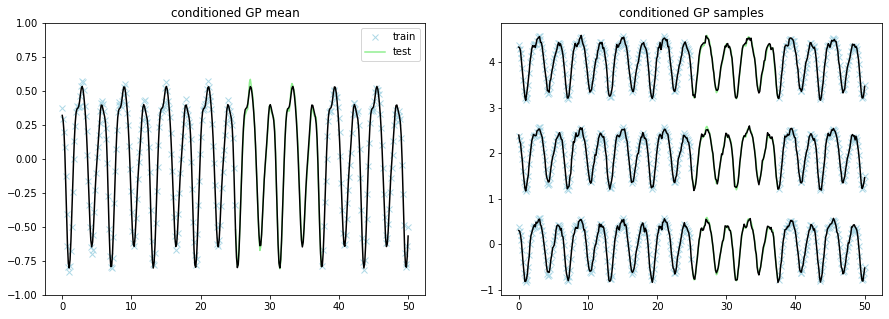

In [14]:
%run display_model.ipy

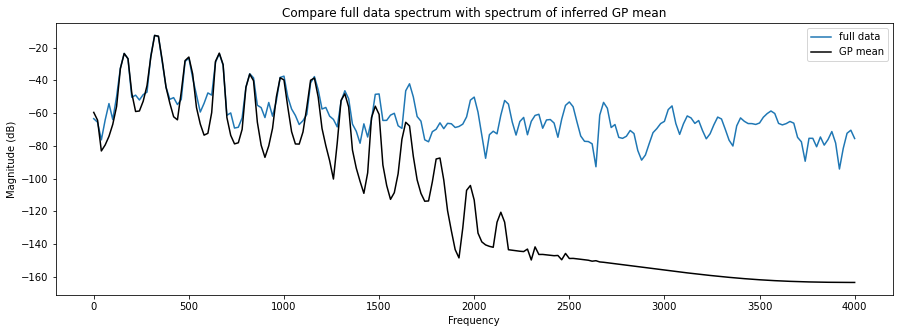

In [15]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(full_T))
    xmean = predictions.mean

title('Compare full data spectrum with spectrum of inferred GP mean')
magnitude_spectrum(full_x, rate, scale='dB', label='full data')
magnitude_spectrum(xmean[:], rate, scale='dB',
                   color='black', label='GP mean')

legend()
show()

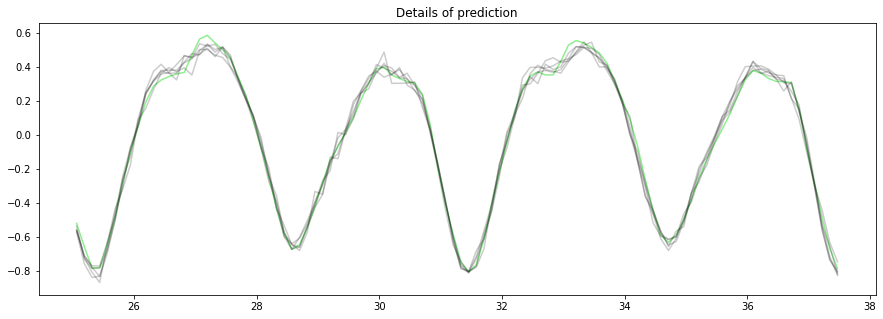

In [16]:
title('Details of prediction')
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_T))
    xmean = predictions.mean
plot(test_t, test_x, color='lightgreen')
n = 5
for i in range(n):
    x0 = multivariate_normal(
        xmean, predictions.covariance_matrix.detach().numpy())
    plot(test_t, x0, alpha=1/n, color='black')

show()

In [17]:
ell_guess_modulator = 50*T0/(2*pi)

kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel() * gpytorch.kernels.PeriodicKernel())
kernel.outputscale = var_x
kernel.base_kernel.kernels[0].lengthscale = ell_guess_modulator
kernel.base_kernel.kernels[1].lengthscale = ell_period_guess
kernel.base_kernel.kernels[1].period_length = T0

likelihood.noise_covar.noise = noise_var
model = ExactGPModel(train_T, train_X, kernel, likelihood)

train_model(model, likelihood)

--- Optimizing hyperparameters ---


--- Signal to Noise Ratio (SNR) ---
Equivalent SNR over full data (dB) = 29.241166266205283
SNR at test data (dB) = 24.578462883904034


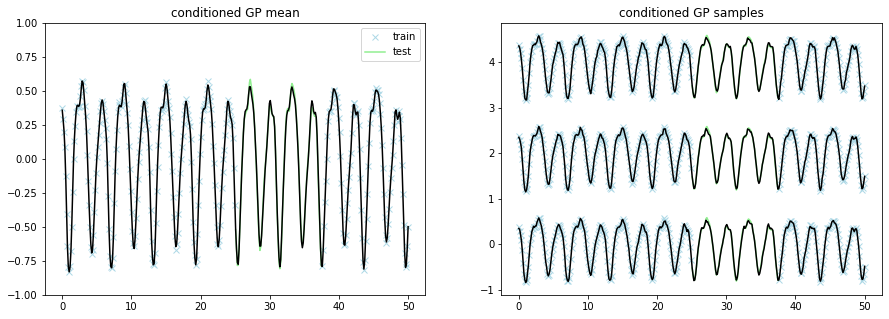

In [18]:
%run display_model.ipy